# QRNN Classification

This notebook uses the QRNN trained on GPM surface precipitation to classify raining and non-raining pixels.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import os

## 

In [47]:
from torch.utils.data import DataLoader
from regn.data import GprofData
rain_threshold = 0.1
path = os.path.expanduser("~/Dendrite/Projects/REGN/data/gprof_gmi")
training_data = GprofData(os.path.join(path, "training_data_small.nc"),
                          batch_size = 64,
                          rain_threshold = rain_threshold)
data.store_normalization_data(os.path.join(path, "normalization_data.nc"))
validation_data = GprofData(os.path.expanduser("~/Dendrite/Projects/REGN/data/gprof_gmi/validation_data_small.nc"),
                            normalization_data=os.path.join(path, "normalization_data.nc"),
                            batch_size = 64,
                            rain_threshold = rain_threshold)

## Defining the model

Since output probabilities for the two classes must sum to 1, a single output is sufficient for binary classification. Another trick we apply here is to combine the output activation function (Sigmoid) with the loss function. The reason for this is that it avoids numerical problems during training. We must only keep in mind that we need to explicitly apply the Sigmoid function during evaluation to get valid probabilities.

In [55]:
import torch
from torch import nn
hidden_width = 128
model = nn.Sequential(
    nn.Linear(training_data.input_features, hidden_width),
    nn.ReLU(),
    nn.Linear(hidden_width, hidden_width),
    nn.ReLU(),
    nn.Linear(hidden_width, hidden_width),
    nn.ReLU(),
    nn.Linear(hidden_width, hidden_width),
    nn.ReLU(),
    nn.Linear(hidden_width, hidden_width),
    nn.ReLU(),
    nn.Linear(hidden_width, hidden_width),
    nn.ReLU(),
    nn.Linear(hidden_width, 1)
)

In [56]:
import torch.optim
from torch.optim import SGD, lr_scheduler
criterion = nn.BCEWithLogitsLoss() # This is the loss that combines Sigmoid with binary cross entropy.
optimizer = SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)

In [58]:
def train_epoch(model,
                training_data,
                validation_data,
                optimizer,
                scheduler,
                device=torch.device("cpu")):
    model = model.to(device)
    
    training_loss = 0
    validation_loss = 0
    n = 0
    
    for i, (x, y) in enumerate(training_data):
        
        optimizer.zero_grad()
        
        x = x.to(device)
        y = y.to(device).view(-1, 1)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        
        optimizer.step()
        
        training_loss += loss.item() * x.size()[0]
        n += x.size()[0]
        training_loss_avg = training_loss / n
        print(f"Batch {i} / {len(training_data)}: Training loss = {training_loss_avg:.3f}", end="\r")
        
    n = 0
    for i, (x, y) in enumerate(validation_data):
        x = x.detach().to(device)
        y = y.detach().to(device).view(-1, 1)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        validation_loss += loss.item() * x.size()[0]
        n += x.size()[0]
        
    validation_loss_avg = validation_loss / n
    scheduler.step(validation_loss_avg)
    model.to(torch.device("cpu"))
    return training_loss_avg, validation_loss_avg

In [59]:
training_errors = []
validation_errors = []
for i in range(100):
    te, ve = train_epoch(model, training_data, validation_data, optimizer, scheduler)
    print(f"Epoch {i}: Training loss = {te:.3f}, Validation loss = {ve:.3f}", end="\n")
    training_errors.append(te)
    validation_errors.append(ve)

Epoch 374: Training loss = 0.178, Validation loss = 0.147
Epoch 374: Training loss = 0.141, Validation loss = 0.149
Epoch 374: Training loss = 0.136, Validation loss = 0.142
Epoch 374: Training loss = 0.134, Validation loss = 0.155
Epoch 374: Training loss = 0.132, Validation loss = 0.139
Epoch 374: Training loss = 0.130, Validation loss = 0.136
Epoch 374: Training loss = 0.128, Validation loss = 0.142
Epoch 374: Training loss = 0.127, Validation loss = 0.142
Epoch 374: Training loss = 0.126, Validation loss = 0.135
Epoch 374: Training loss = 0.125, Validation loss = 0.145
Epoch 374: Training loss = 0.124, Validation loss = 0.134
Epoch 374: Training loss = 0.123, Validation loss = 0.135
Epoch 374: Training loss = 0.123, Validation loss = 0.136
Epoch 374: Training loss = 0.122, Validation loss = 0.133
Epoch 374: Training loss = 0.121, Validation loss = 0.138
Epoch 374: Training loss = 0.120, Validation loss = 0.150
Epoch 374: Training loss = 0.120, Validation loss = 0.136
Epoch 374: Tra

Text(0, 0.5, 'Loss')

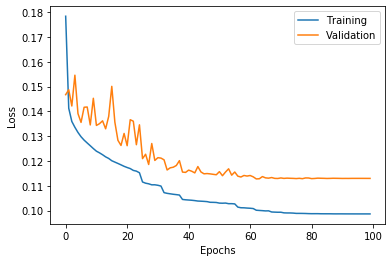

In [62]:
plt.plot(training_errors, label="Training")
plt.plot(validation_errors, label="Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [64]:
torch.save(model, "nn_6_128.pt")

## Evaluation

In [91]:
correct = 0
correct_rain = 0
total = 0
total_rain = 0
for i, d in enumerate(validation_data):
    
        inputs, labels = d
        labels = labels.view(-1, 1)

        outputs = torch.sigmoid(model(inputs))
        
        # find the index with maximum energy
        predicted = outputs > 0.5
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        correct_rain += ((predicted ==1) * (labels == 1)).sum().item()
        total_rain += (labels==1).sum().item()
print('Accuracy of the network: %d %%' % (
    100 * correct / total))  
print('Accuracy of the predicting rain: %d %%' % (
    100 * correct_rain / total_rain))  

Accuracy of the network: 95 %
Accuracy of the predicting rain: 67 %
